## Importamos librerias necesarias

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

## Se importan dataset de prueba y entrenamiento, se agrega columna de variable target y se unifican

In [3]:
path = 'TestDataset2/DatosTrainingCompletos2.csv' #datos de entrenamiento
datos_train = pd.read_csv(path)
path = 'TrainDataset/TrainLabels.csv' #resultados obtenidos en DAISEE
labels_train = pd.read_csv(path)
merged = pd.merge(left=datos_train,right=labels_train, left_on='ClipID', right_on='ClipID')

In [4]:
# ==============================================================================
path = 'TestDataset2/DatosTestCompletos2.csv' #datos de prueba
datos_test = pd.read_csv(path)
path = 'TestDataset2/TestLabels.csv' #resultados obtenidos en DAISEE
labels_test = pd.read_csv(path)
## Se combinan ambos datos, y se realiza un join a traves de la columna Clip ID para asegurar que cada fila refleja el resultado del video correcto
# ==============================================================================
merged2 = pd.merge(left=datos_test,right=labels_test, left_on='ClipID', right_on='ClipID')
datos_completos=pd.concat([merged,merged2],ignore_index=True)
datos_completos=datos_completos.drop('ClipID', axis = 'columns')

# Modelo Engagement

## Procesamiento de datos para modelo engagement

In [5]:
datos_engagement=datos_completos.drop(columns=['Boredom','Confusion','Frustration ']) #se eliminan columnas de Boredom, Confusion y Frustration
datos_engagement['Engagement']= datos_engagement['Engagement'].replace(0,1) 
# ==============================================================================
# Debido a que hay muy pocas muestras con resultado cero, se reemplazan con las muestras de resultado uno

In [6]:
# Para balancear el dataset obtenido se toman la misma cantidad de muestras obtenidas por cada valor: "1,2,3"
# ==============================================================================
df=datos_engagement[(datos_engagement.Engagement==1)] 
df1=datos_engagement[(datos_engagement.Engagement==2)]
df1=df1.iloc[0:len(df)]
df2=datos_engagement[(datos_engagement.Engagement==3)]
df2=df2.iloc[0:len(df)]
datosbalanceados_engagement=pd.concat([df,df1,df2],ignore_index=True) #Luego se combinan para formar un dataset con muestras balanceadas para utilizar en el modelo
datosbalanceados_engagement.shape

(2970, 1496)

In [35]:
freq = datosbalanceados_engagement.groupby(['Engagement']).count() 
print(freq)

            px_0  py_0  pz_0  px_1  py_1  pz_1  px_2  py_2  pz_2  px_3  ...  \
Engagement                                                              ...   
1            990   990   990   990   990   990   990   990   990   990  ...   
2            990   990   990   990   990   990   990   990   990   990  ...   
3            990   990   990   990   990   990   990   990   990   990  ...   

            au14  au12  au2  au11  au23  au6  au1  au4  au25  au9  
Engagement                                                         
1            990   990  990   990   990  990  990  990   990  990  
2            990   990  990   990   990  990  990  990   990  990  
3            990   990  990   990   990  990  990  990   990  990  

[3 rows x 1495 columns]


## Dividir datos en entrenamiento y test, creacion de modelo usando SVM

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datosbalanceados_engagement.drop('Engagement', axis = 'columns'),
                                        datosbalanceados_engagement['Engagement'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [37]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 1000, kernel = 'linear',gamma=1, random_state=123)
modelo.fit(X_train, y_train)

SVC(C=1000, gamma=1, kernel='linear', random_state=123)

## Resultado de precision y matriz de confusion

In [38]:
# Se crea prediccion del modelo y se evalua con el parametro accuracy
# ==============================================================================
predicciones = modelo.predict(X_test)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 93.26599326599326%


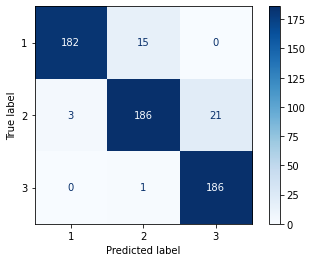

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, predicciones, cmap=plt.cm.Blues)

In [40]:
with open("EngagementProduccion.pickle", "wb") as f:
    pickle.dump(modelo, f)

In [42]:
X_train.head()

,px_0,py_0,pz_0,px_1,py_1,pz_1,px_2,py_2,pz_2,px_3,...,au14,au12,au2,au11,au23,au6,au1,au4,au25,au9
1758,0.607971,0.456334,-0.582226,0.619692,0.404131,-0.556028,0.630962,0.401428,-0.555608,0.641876,...,8,1,6,3,1,2,5,4,6,1
519,0.515994,0.547110,-3.070136,0.560851,0.452305,-3.015197,0.586232,0.449883,-3.015527,0.606303,...,0,2,5,1,4,1,4,3,6,0
2731,0.531908,0.717264,-1.100434,0.557936,0.662062,-1.044221,0.572559,0.664665,-1.044578,0.588964,...,7,2,6,1,1,3,4,3,7,1
1526,0.597895,0.460180,-0.490422,0.616870,0.421516,-0.449988,0.628382,0.422402,-0.449728,0.639378,...,8,1,8,1,8,3,6,5,6,2
1508,0.638720,0.477430,-0.498970,0.653526,0.437295,-0.458080,0.663807,0.437210,-0.457772,0.673490,...,8,2,7,0,0,2,5,5,7,1


# Modelo Confusion

## Procesamiento de datos para modelo confusion

In [13]:
datos_confusion=datos_completos.drop(columns=['Boredom','Engagement','Frustration ']) #se eliminan columnas de Boredom, Confusion y Frustration
datos_confusion['Confusion']= datos_confusion['Confusion'].replace(3,2) 
# ==============================================================================
# Debido a que hay muy pocas muestras con resultado "tres", se reemplazan con las muestras de resultado "dos"

In [14]:
# Para balancear el dataset obtenido se toman la misma cantidad de muestras obtenidas por cada valor: "0,1,2"
# ==============================================================================
df=datos_confusion[(datos_confusion.Confusion==2)] 
df1=datos_confusion[(datos_confusion.Confusion==1)]
df1=df1.iloc[0:len(df)]
df2=datos_confusion[(datos_confusion.Confusion==0)]
df2=df2.iloc[0:len(df)]
datosbalanceados_confusion=pd.concat([df,df1,df2],ignore_index=True) #Luego se combinan para formar un dataset con muestras balanceadas para utilizar en el modelo
datosbalanceados_confusion.shape

(6090, 1496)

In [15]:
freq = datosbalanceados_confusion.groupby(['Confusion']).count() # se comprueba que esten balanceados
print(freq)

           px_0  py_0  pz_0  px_1  py_1  pz_1  px_2  py_2  pz_2  px_3  ...  \
Confusion                                                              ...   
0          2030  2030  2030  2030  2030  2030  2030  2030  2030  2030  ...   
1          2030  2030  2030  2030  2030  2030  2030  2030  2030  2030  ...   
2          2030  2030  2030  2030  2030  2030  2030  2030  2030  2030  ...   

           au14  au12   au2  au11  au23   au6   au1   au4  au25   au9  
Confusion                                                              
0          2030  2030  2030  2030  2030  2030  2030  2030  2030  2030  
1          2030  2030  2030  2030  2030  2030  2030  2030  2030  2030  
2          2030  2030  2030  2030  2030  2030  2030  2030  2030  2030  

[3 rows x 1495 columns]


## Dividir datos en entrenamiento y test, creacion de modelo usando SVM

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datosbalanceados_confusion.drop('Confusion', axis = 'columns'),
                                        datosbalanceados_confusion['Confusion'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [17]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 100, kernel = 'rbf', gamma=0.001, random_state=123)
modelo.fit(X_train, y_train)

SVC(C=100, gamma=0.001, random_state=123)

## Resultado de precision y matriz de confusion

In [18]:
# Se crea prediccion del modelo y se evalua con el parametro accuracy
# ==============================================================================
predicciones = modelo.predict(X_test)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 79.63875205254516%


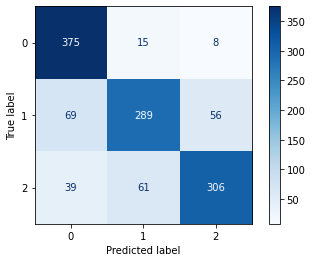

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, predicciones, cmap=plt.cm.Blues)

In [20]:
with open("ConfusionProduccion.pickle", "wb") as f:
    pickle.dump(modelo, f)

# Modelo Frustration

## Procesamiento de datos para modelo frustration

In [21]:
datos_frustration=datos_completos.drop(columns=['Boredom','Engagement','Confusion']) #se eliminan columnas de Boredom, Confusion y Engagement
datos_frustration = datos_frustration.rename(columns={'Frustration ':'Frustration'})
datos_frustration['Frustration']= datos_frustration['Frustration'].replace(3,2) 
# ==============================================================================
# Debido a que hay muy pocas muestras con resultado "tres", se reemplazan con las muestras de resultado "dos"

In [22]:
# Para balancear el dataset obtenido se toman la misma cantidad de muestras obtenidas por cada valor: "0,1,2"
# ==============================================================================
df=datos_frustration[(datos_frustration.Frustration==2)] 
df1=datos_frustration[(datos_frustration.Frustration==1)]
df1=df1.iloc[0:len(df)]
df2=datos_frustration[(datos_frustration.Frustration==0)]
df2=df2.iloc[0:len(df)]
datosbalanceados_frustration=pd.concat([df,df1,df2],ignore_index=True) #Luego se combinan para formar un dataset con muestras balanceadas para utilizar en el modelo
datosbalanceados_frustration.shape

(3780, 1496)

In [23]:
freq = datosbalanceados_frustration.groupby(['Frustration']).count() # se comprueba que esten balanceados
print(freq)

             px_0  py_0  pz_0  px_1  py_1  pz_1  px_2  py_2  pz_2  px_3  ...  \
Frustration                                                              ...   
0            1260  1260  1260  1260  1260  1260  1260  1260  1260  1260  ...   
1            1260  1260  1260  1260  1260  1260  1260  1260  1260  1260  ...   
2            1260  1260  1260  1260  1260  1260  1260  1260  1260  1260  ...   

             au14  au12   au2  au11  au23   au6   au1   au4  au25   au9  
Frustration                                                              
0            1260  1260  1260  1260  1260  1260  1260  1260  1260  1260  
1            1260  1260  1260  1260  1260  1260  1260  1260  1260  1260  
2            1260  1260  1260  1260  1260  1260  1260  1260  1260  1260  

[3 rows x 1495 columns]


## Dividir datos en entrenamiento y test, creacion de modelo usando SVM

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datosbalanceados_frustration.drop('Frustration', axis = 'columns'),
                                        datosbalanceados_frustration['Frustration'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [25]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 10, kernel = 'rbf', gamma=0.01, random_state=123)
modelo.fit(X_train, y_train)

SVC(C=10, gamma=0.01, random_state=123)

## Resultado de precision y matriz de confusion

In [26]:
# Se crea prediccion del modelo y se evalua con el parametro accuracy
# ==============================================================================
predicciones = modelo.predict(X_test)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 89.41798941798942%


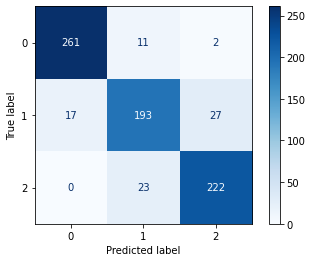

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, predicciones, cmap=plt.cm.Blues)

In [28]:
with open("FrustrationProduccion.pickle", "wb") as f:
    pickle.dump(modelo, f)